In [ ]:
### 설치
!pip install keras

In [15]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import RandomSampler, SequentialSampler

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
train = pd.read_csv('review_train.csv', encoding='utf-8')
test = pd.read_csv('review_test.csv', encoding='utf-8')

In [3]:
### label encoding
from sklearn.preprocessing import LabelEncoder
n = train.shape[0]
y = pd.concat([train,test])

le = LabelEncoder()
y['keyword2'] = le.fit_transform(y['keyword2'])
train = y[:n]
test = y[n:]

In [4]:
### train/valid split
train, valid = train_test_split(
    train, test_size=0.2, shuffle=True, random_state=2024
)

In [5]:
### tokenizer
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

In [6]:
### GPT classifier model
class GPTClassifier(nn.Module):
  def __init__(self, num_classes=13):
    super(GPTClassifier, self).__init__()
    self.num_classes = num_classes
    self.gpt = AutoModel.from_pretrained('skt/kogpt2-base-v2')
    self.fc = nn.Linear(768, num_classes, bias=False)

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
    output = self.fc(output.last_hidden_state)
    output = output[:, -1, :]
    return output

### model 선언
model = GPTClassifier()
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [7]:
### DataLoader - train
tokenized_texts = [tokenizer.tokenize(s) for s in train['reviews']]

MAX_LEN = 512
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long',
                          truncating='post', padding='post')
attention_masks = []

for seq in tqdm(input_ids):
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(train['keyword2'].values)
train_masks = torch.tensor(attention_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=2)

100%|██████████| 1620/1620 [00:00<00:00, 2887.04it/s]


In [8]:
### training setting
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()
epochs = 10

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
### train
for epoch in range(epochs):
  print('---------------------------------------------')
  print(f'[Epoch] {epoch+1}')

  print('Train Mode :', end=" ")
  total_loss, train_accuracy = 0.0, 0.0
  model.train()

  for batch in tqdm(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()

    outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

    loss = criterion(outputs, b_labels)
    total_loss += loss.item()
    loss.backward()

    logits = outputs.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    train_accuracy += flat_accuracy(logits, label_ids)

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

  avg_train_loss = total_loss / len(train_dataloader)
  avg_train_acc = train_accuracy / len(train_dataloader)

  print(" Average training loss: {0:.4f}".format(avg_train_loss), end=" ")
  print(" Average training accuracy: {0:.4f}".format(avg_train_acc), end=" ")

torch.save(model.state_dict(), 'best_model.pth')

---------------------------------------------
[Epoch] 1
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.10it/s]


 Average training loss: 0.0829  Average training accuracy: 0.9846 ---------------------------------------------
[Epoch] 2
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.10it/s]


 Average training loss: 0.0672  Average training accuracy: 0.9858 ---------------------------------------------
[Epoch] 3
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.10it/s]


 Average training loss: 0.0536  Average training accuracy: 0.9864 ---------------------------------------------
[Epoch] 4
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.10it/s]


 Average training loss: 0.0567  Average training accuracy: 0.9877 ---------------------------------------------
[Epoch] 5
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.09it/s]


 Average training loss: 0.0577  Average training accuracy: 0.9852 ---------------------------------------------
[Epoch] 6
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.10it/s]


 Average training loss: 0.0725  Average training accuracy: 0.9883 ---------------------------------------------
[Epoch] 7
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.11it/s]


 Average training loss: 0.0281  Average training accuracy: 0.9926 ---------------------------------------------
[Epoch] 8
Train Mode : 

100%|██████████| 810/810 [03:16<00:00,  4.12it/s]


 Average training loss: 0.0907  Average training accuracy: 0.9864 ---------------------------------------------
[Epoch] 9
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.10it/s]


 Average training loss: 0.0813  Average training accuracy: 0.9815 ---------------------------------------------
[Epoch] 10
Train Mode : 

100%|██████████| 810/810 [03:17<00:00,  4.11it/s]


 Average training loss: 0.0631  Average training accuracy: 0.9870 

In [12]:
### evaluation
tokenized_texts = [tokenizer.tokenize(s) for s in valid['reviews']]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

valid_inputs = torch.tensor(input_ids)
valid_labels = torch.tensor(valid['keyword2'].values)
valid_masks = torch.tensor(attention_masks)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=2)

100%|██████████| 203/203 [00:12<00:00, 15.87it/s]


Valid Accuracy: 0.8374
Valid F1 Score: 0.8337


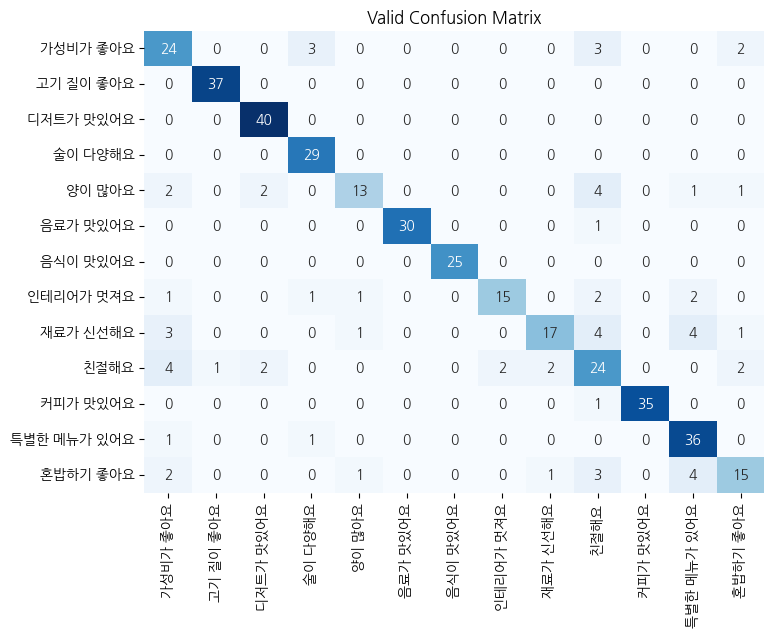

In [16]:
model.eval()

preds = []
true_labels = []

for batch in tqdm(valid_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

  logits = outputs.detach().cpu().numpy()
  preds.extend(np.argmax(logits, axis=1))
  true_labels.extend(b_labels.cpu().numpy())

preds = np.array(preds)
true_labels = np.array(true_labels)

acc = accuracy_score(true_labels, preds)
mtx = confusion_matrix(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')

print(f'Valid Accuracy: {acc:.4f}')
print(f'Valid F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(mtx, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Valid Confusion Matrix')
plt.show()

In [17]:
### Predict
tokenized_texts = [tokenizer.tokenize(s) for s in test['reviews']]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(test['keyword2'].values)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=2)

100%|██████████| 200/200 [00:12<00:00, 15.82it/s]


Test Accuracy: 0.2975
Test F1 Score: 0.2941


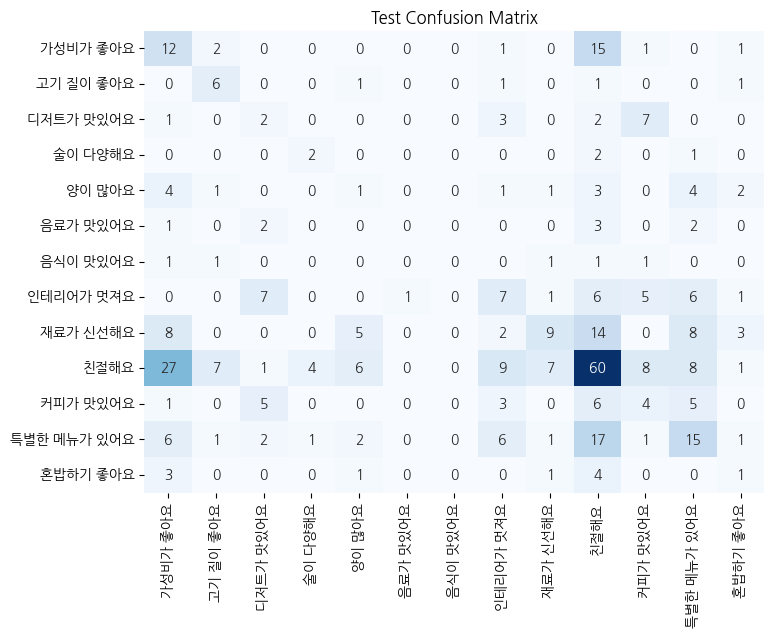

In [18]:
model.eval()

preds = []
true_labels = []

for batch in tqdm(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

  logits = outputs.detach().cpu().numpy()
  preds.extend(np.argmax(logits, axis=1))
  true_labels.extend(b_labels.cpu().numpy())

preds = np.array(preds)
true_labels = np.array(true_labels)

acc = accuracy_score(true_labels, preds)
mtx = confusion_matrix(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')

print(f'Test Accuracy: {acc:.4f}')
print(f'Test F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(mtx, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Test Confusion Matrix')
plt.show()